In [32]:
import pickle
from math import floor
from IPython.display import display, clear_output
import scipy.stats
from pylab import * 
from collections import OrderedDict
import numpy as np
import seaborn as sns
import pandas
from itertools import product as iterproduct, groupby
%matplotlib inline
%run "/home/ibis/gregor.sturm/nanopore/own/notebooks/03_pipeline/analysis_lib.ipynb"
sns.set_style("ticks", {"axes.grid" : True, "grid.color" : ".95"})
matplotlib.rcParams.update({'font.size': 16})

In [33]:
# args = {
#     "true_events": "/home/ibis/gregor.sturm/nanopore/own/notebooks/03_pipeline/david_alignment_true_events.pickle",
#     "ref": "/home/ibis/gregor.sturm/nanopore/david_eccles_bc_ideas/mouse_ref.fa",
# }

args = {
    "true_events": "/home/ibis/gregor.sturm/nanopore/own/notebooks/03_pipeline/lambda_alignment_bwa_true_events.pickle",
    "ref": "/home/ibis/gregor.sturm/nanopore/own/notebooks/03_pipeline/lambda_ref.fasta",
}

In [34]:
NMER = 5
CONTEXT = 200

In [35]:
!pwd

/home/ibis/gregor.sturm/nanopore/own/notebooks


In [36]:
true_events = pickle.load(open(args["true_events"], 'rb'))

In [37]:
ref_file = args["ref"]
test = !cat {ref_file} | grep ">"
print(test)
ref = !cat {ref_file} | grep -v ">"
ref = ref[0]
print(ref[:100])

['>burn-in lambda_ref']
GGGCGGCGACCTCGCGGGTTTTCGCTATTTATGAAAATTTTCCGGTTTAAGGCGTTTCCGTTCTTCTTCGTCATAACTTAATGTTTTTATTTAAAATACC


In [38]:
def get_context(event, start, end):
    """get the nt-context around the kmer. 
    E.g. start=-20: get context 20nt before the reference point
    (mid of kmer)"""
    ref_pos = event["ref_position"]
    start = ref_pos + start
    end = ref_pos + end
    context = ref[start:end]
    if len(context) != end-start:
        print(start, end, len(ref), len(context), end-start)
        raise IndexError
    else: return context

def get_context_before(event, n):
    """get n nucleotides before the start of the kmer"""
    length = len(event["kmer"])
    offset = int(-floor(length/2))
    return get_context(event, -n+offset, offset)
    
def get_context_after(event, n):
    length = len(event["kmer"])
    offset = int(floor(length/2) + 1)
    return get_context(event, offset, offset+n)

In [39]:
test_event = true_events[1024]
assert test_event['kmer'] == get_context(test_event, -2, 2+1), "invalid reference"
assert (get_context_before(test_event, 20) 
        + test_event['kmer'] 
        + get_context_after(test_event, 20)) == (
    get_context(test_event, -22, 22+1))

## Analysis 

In [40]:
all_5mers = mk_kmer_dict(NMER)
ev_map = mk_event_map(true_events, all_5mers)

In [41]:
def prepare_events(kmer):
    template_events = [ev for ev in ev_map[kmer] if not np.isnan(ev["template.mean"])]
    template_events = [ev for ev in template_events if 
                   ev["ref_position"] > CONTEXT+NMER+1 and ev["ref_position"] < len(ref)-CONTEXT-NMER-1]
    print("kmer {0}".format(kmer))
    print(">>genomic_positions {0}".format(len(set([ev["ref_position"] for ev in template_events]))))
    print(">>total_events {0}".format(len(template_events)))
    return template_events

In [42]:
def stratify_by_position(template_events, skip=10):
    """group events by genomic positions. 
    
    Args: 
        template_events: list of events
        skip: skip genomic positions with less than {skip} events. 
    
    Returns: 
        dict pos => (mean, stdv, context_before, context_after) of the
        given position. 
    """
    sort_position = lambda x: x["ref_position"]
    template_events = sorted(template_events, key=sort_position)
    groups = {key: [x for x in group] for key, group in groupby(template_events, sort_position)}
    genomic_pos = OrderedDict()
    for key, group in groups.items():
        means = [x["template.mean"] for x in group]
        if(len(means) < skip): 
#             print("skipped {0}".format(key))
            continue
        else:
            assert get_context_before(group[0], CONTEXT) == get_context_before(group[-1], CONTEXT)
            genomic_pos[key] = {
                "event_means" : means,
                "mean" : np.mean(means),
                "stdv" : np.std(means),
                "context_before": get_context_before(group[0], CONTEXT),
                "context_after": get_context_after(group[0], CONTEXT)
        }
    
    return genomic_pos                                                       

kmer AAAAA
>>genomic_positions 133
>>total_events 2207


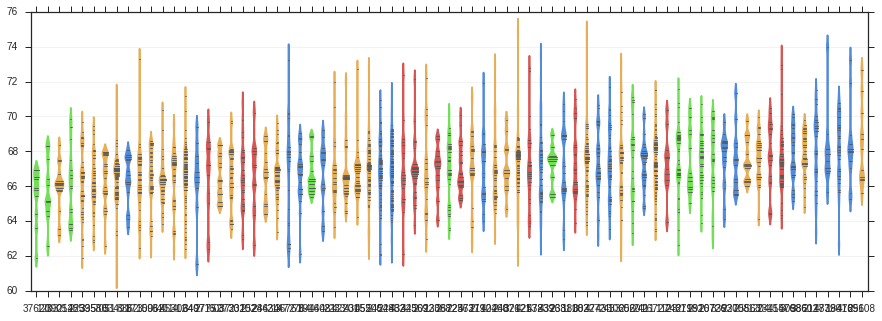

kmer AAAAC
>>genomic_positions 126
>>total_events 4534


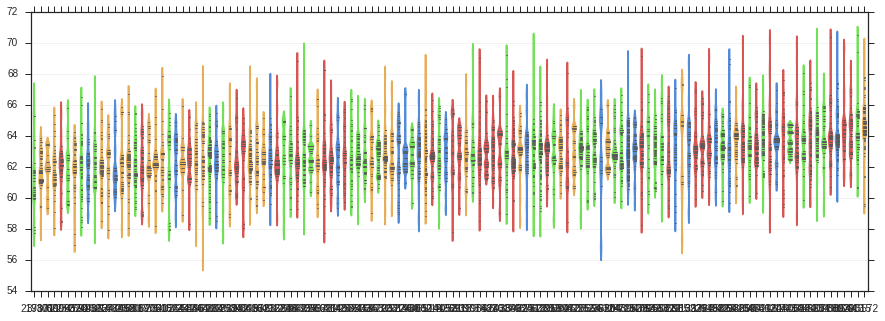

kmer AAAAG
>>genomic_positions 73
>>total_events 1800


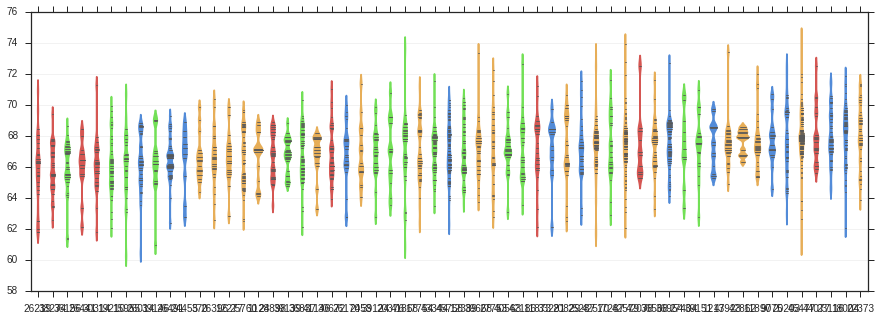

kmer AAAAT
>>genomic_positions 87
>>total_events 2821


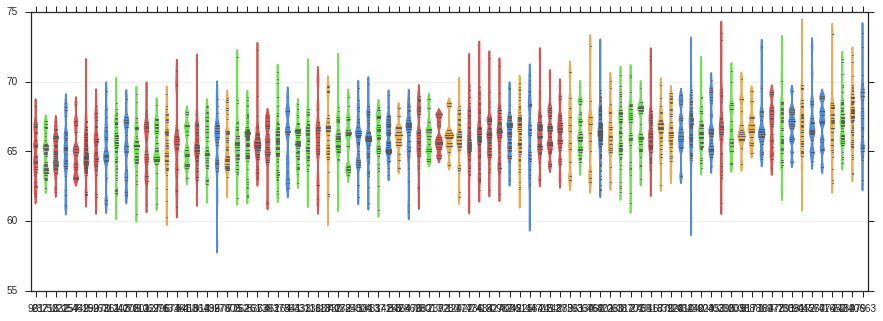

kmer AAACA
>>genomic_positions 82
>>total_events 3874


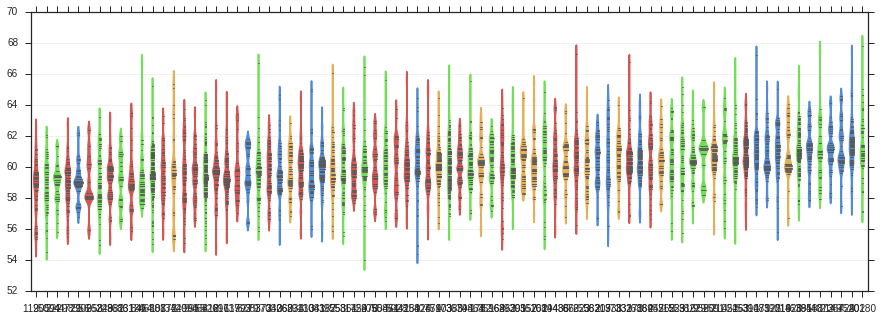

kmer AAACC
>>genomic_positions 68
>>total_events 2999


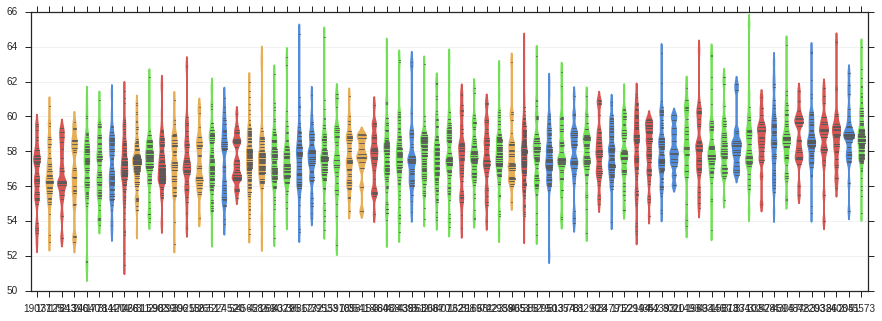

kmer AAACG
>>genomic_positions 77
>>total_events 3273


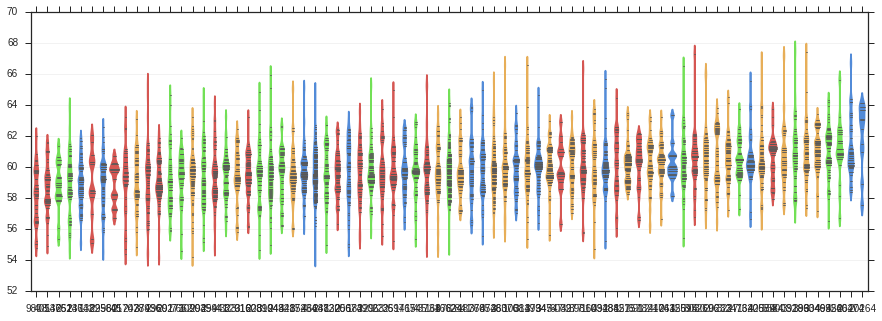

kmer AAACT
>>genomic_positions 48
>>total_events 2225


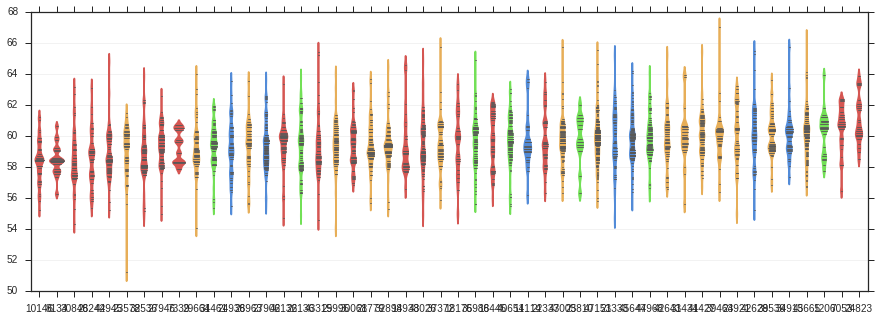

kmer AAAGA
>>genomic_positions 87
>>total_events 2597


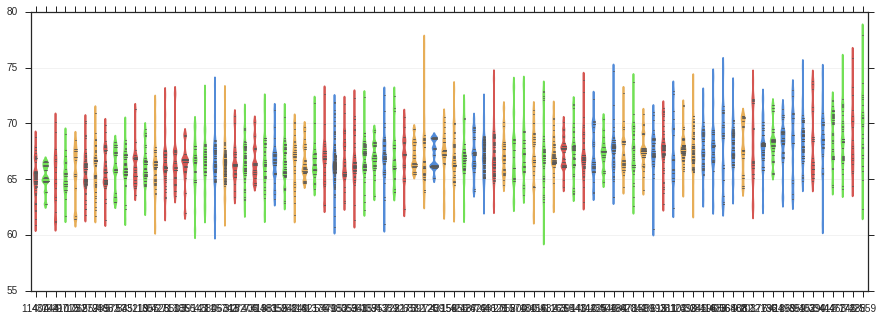

kmer AAAGC
>>genomic_positions 71
>>total_events 2760


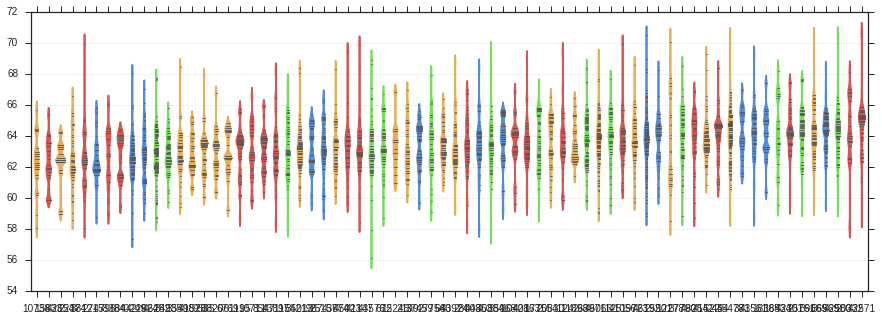

kmer AAAGG
>>genomic_positions 60
>>total_events 1454


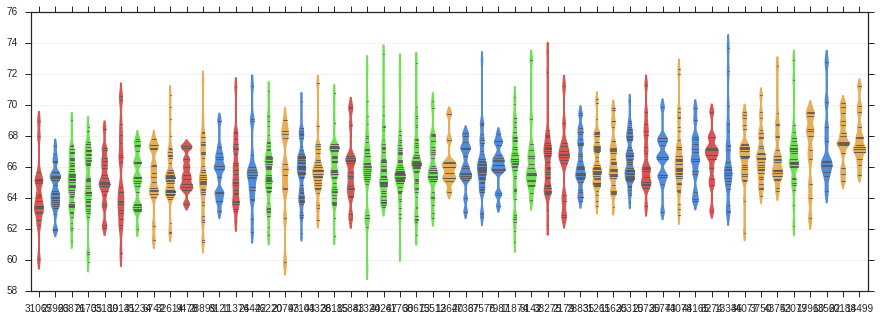

kmer AAAGT
>>genomic_positions 41
>>total_events 1506


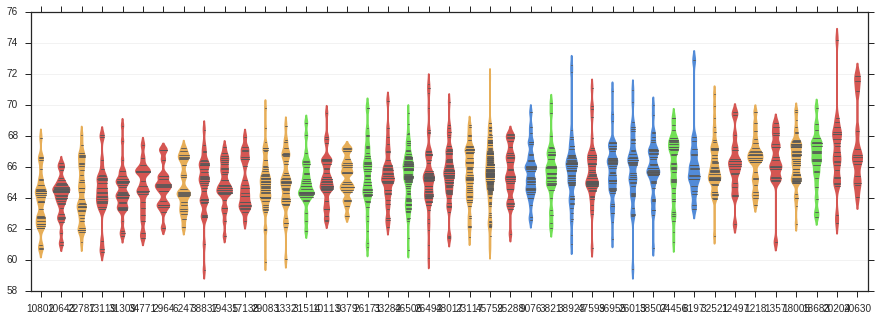

kmer AAATA
>>genomic_positions 70
>>total_events 3643


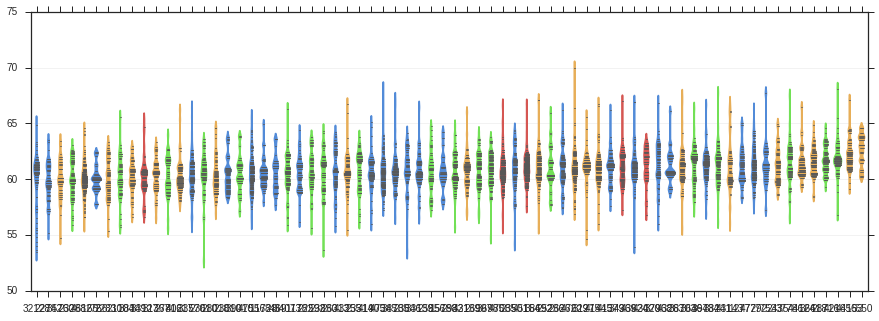

kmer AAATC
>>genomic_positions 75
>>total_events 3489


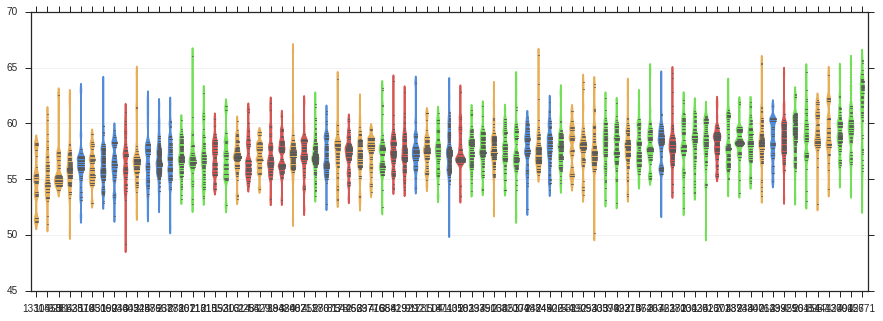

kmer AAATG
>>genomic_positions 68
>>total_events 2894


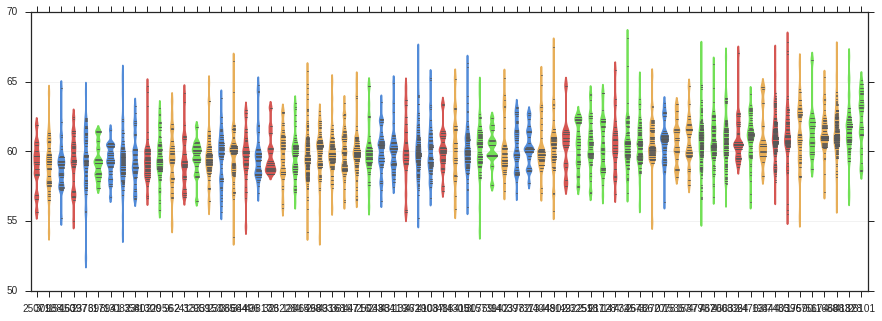

kmer AAATT
>>genomic_positions 64
>>total_events 2841


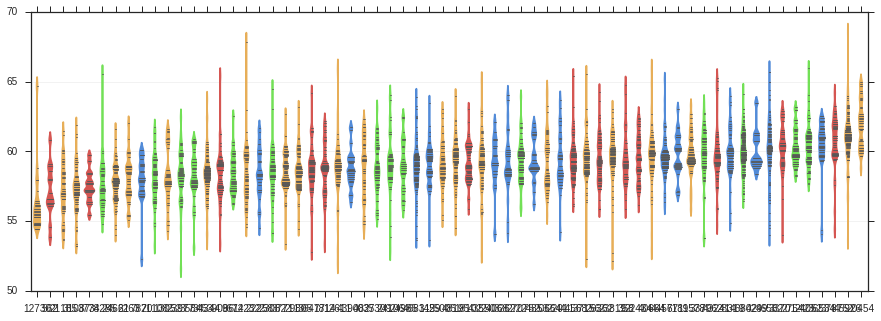

kmer AACAA
>>genomic_positions 71
>>total_events 3443


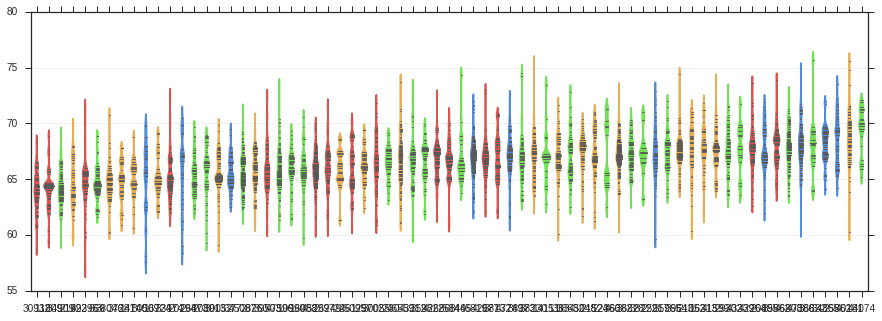

kmer AACAC
>>genomic_positions 42
>>total_events 1634


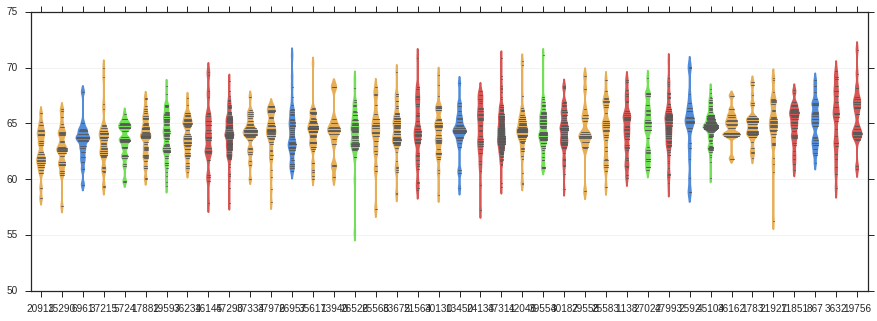

kmer AACAG
>>genomic_positions 87
>>total_events 3854


KeyboardInterrupt: 

KeyError: (0.0, 75.0, '75', '.15', 'center', 'right', -8203804769534045528, None, None, 72.0, 139699455468376)

In [43]:
for kmer in ev_map.keys():
    fig, ax = subplots(figsize=(15,5))
    template_events = prepare_events(kmer)
    genomic_pos = stratify_by_position(template_events)
    mlen = np.max([len(x["event_means"]) for x in genomic_pos.values()])
    d = [(pos,
          x["event_means"] + [np.nan for _ in range(len(x["event_means"]), mlen)],
          x["context_after"][0]) for pos, x in genomic_pos.items()]
    d = sorted(d, key=lambda x: np.nanmean(x[1]))
    data = pandas.DataFrame(OrderedDict((pos, means) for pos, means, _ in d))
    colors = [NT_COLORS[nt] for _, _, nt in d]
    sns.violinplot(data=data,
                   bw=0.15, ax=ax, inner="stick", inner_kws={}, scale_hue=False, palette=sns.color_palette(colors))
    display(fig)
    plt.close()